This file performs linear regression, regularized linear regression, linear regression with polynomial features, and regularized linear regression with polynomial features.

In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [22]:
# Import training and test sets
data_train = pd.read_csv('../data/data_train.csv')
data_test = pd.read_csv('../data/data_test.csv')

# Select variables
y_train = data_train['SalePrice']
x_train = data_train.drop(['SalePrice'], axis=1)

y_test = data_test['SalePrice']
x_test = data_test.drop(['SalePrice'], axis=1)

# Find continuous features/columns
cont_cols = []
for col in x_train.columns:
    if data_train[col].value_counts().index.to_list() not in [[0, 1], [1, 0], [1], [0]]:
        cont_cols.append(col)

Min value of cluster 1 is:  294000
Max value of cluster 1 is:  755000
Min value of cluster 2 is:  34900
Max value of cluster 2 is:  174000
Min value of cluster 3 is:  174500
Max value of cluster 3 is:  293077


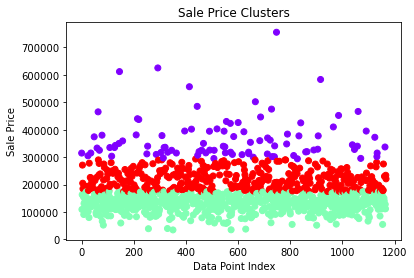

In [10]:
# Group homes into three groups: low-priced, medium-priced, and high-priced
# We will use these groups to examine the fairness of our models
cluster = KMeans(n_clusters=3, random_state=3)
cluster.fit(y_train.values.reshape(-1,1))

# Print cluster thresholds
for i in range(3):
    print('Min value of cluster', i+1, 'is: ', y_train[cluster.labels_==i].min())
    print('Max value of cluster', i+1, 'is: ', y_train[cluster.labels_==i].max())

# Plot clusters
colormap = cm.rainbow(np.linspace(0, 1, len(cluster.cluster_centers_)))
plt.scatter(y_train.index, y_train, c=colormap[cluster.labels_])
plt.title('Sale Price Clusters')
plt.ylabel('Sale Price')
plt.xlabel('Data Point Index')
plt.show()
    
# Extract cluster thresholds
low_cluster_threshold = y_train.max()
high_cluster_threshold = y_train.min()
for i in range(3):
    cluster_threshold = y_train[cluster.labels_==i].max()
    if cluster_threshold < low_cluster_threshold:
        low_cluster_threshold = cluster_threshold
    if cluster_threshold > high_cluster_threshold and cluster_threshold < y_train.max():
        high_cluster_threshold = cluster_threshold


# Load function for computing model evaluation metrics
def metrics(y_test, y_test_hat):
    '''
    Compute and print model evaluation metrics.
    '''
    mae = mean_absolute_error(y_test, y_test_hat)
    mse = mean_squared_error(y_test, y_test_hat)
    r2 = r2_score(y_test, y_test_hat)
    print("""\n Evaluation metrics: \n
             MAE: {} \n
             MSE: {} \n
             R2: {} \n""".format(mae, mse, r2))
    
    # Print the descriptive statistics for the predictive error of low- and high-priced homes, respectively
    error = y_test - y_test_hat
    low_stats = error[y_test <= low_cluster_threshold].describe()
    high_stats = error[y_test > high_cluster_threshold].describe()
    print("""Descriptive statistics for the predictive error among low-priced homes: \n {} \n
             Descriptive statistics for the predictive error among high-priced homes: \n {}""".format(low_stats, high_stats))

       Condition2_PosN      PoolQC_Ex  GarageCond_Ex     PoolQC_Fa  \
coeff   -471147.610693 -190217.177712   -95139.74659 -82909.796573   

       MiscFeature_Gar2  GarageYrBlt_1910.0  Condition2_RRAe  \
coeff     -81536.733054        -73458.55439    -72514.554948   

       HouseStyle_2.5Fin  Electrical_Mix     PoolQC_Gd  LandSlope_Sev  \
coeff       -72468.37296    -65003.85126 -49748.332291  -44537.094973   

       MSSubClass_45  RoofMatl_Roll  Heating_OthW  Exterior1st_BrkComm  \
coeff  -41744.359387   -38585.66036 -34018.236866        -32921.210233   

       HouseStyle_2.5Unf  GarageQual_Fa  SaleCondition_Partial  \
coeff      -32557.362189  -32201.629721            -29632.5646   

       Utilities_NoSeWa  Functional_Mod  MSZoning_C (all)  Functional_Maj2  \
coeff      -28748.72432   -28057.869673     -26755.878345     -26461.20567   

       GarageQual_TA  Condition1_RRAe   Street_Grvl  Functional_Maj1  \
coeff   -25894.21871    -24698.962792 -24464.975723    -23088.536285   


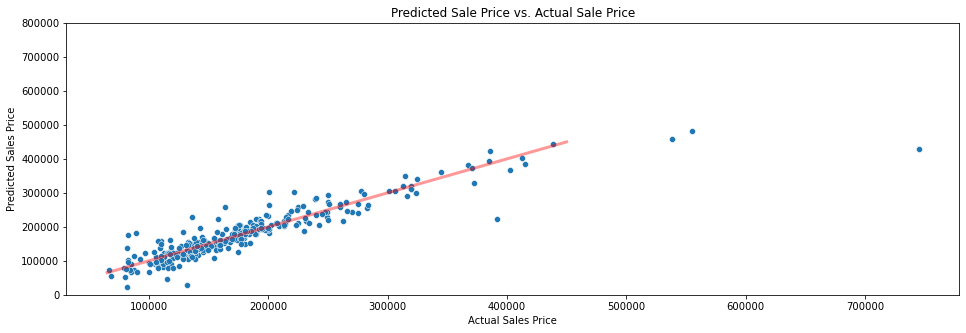

In [30]:
pd.set_option('display.max_columns', None)

# Fit the linear regression
ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols)
    ], remainder='passthrough')
pipeline = Pipeline([
    ('norm', ct),
    ('regr', linear_model.LinearRegression()),
])
pipeline.fit(x_train, y_train)

# Print coefficients
coeffs = pd.DataFrame(data=np.reshape(pipeline['regr'].coef_, (1,-1)), columns=x_train.columns, index=['coeff'] )
print(coeffs.sort_values(by='coeff', axis=1))

# Predict housing values for the test set
y_test_hat = pipeline.predict(x_test)

# Compute model evaluation metrics
metrics(y_test, y_test_hat)

# Plot actual vs. predicted
plt.figure(figsize=(16,5))
plot = sns.scatterplot(x=y_test, y=y_test_hat)
plot.set(xlabel='Actual Sales Price', ylabel='Predicted Sales Price')
plot.set_title('Predicted Sale Price vs. Actual Sale Price')
plt.plot(np.array([65000.,450000.]), np.array([65000.,450000.]), color='red', alpha=0.4, linewidth=3)
plt.ylim((0,800000))
plt.show()

                    params  mean_test_neg_mean_squared_error  \
0    {'Lasso__alpha': 0.1}                     -1.049980e+09   
1      {'Lasso__alpha': 1}                     -9.997006e+08   
10  {'Lasso__alpha': 1000}                     -8.853606e+08   
2     {'Lasso__alpha': 10}                     -8.576947e+08   
9    {'Lasso__alpha': 550}                     -8.538398e+08   
8    {'Lasso__alpha': 500}                     -8.504400e+08   
7    {'Lasso__alpha': 450}                     -8.474105e+08   
6    {'Lasso__alpha': 350}                     -8.338866e+08   
5    {'Lasso__alpha': 300}                     -8.199717e+08   
4    {'Lasso__alpha': 250}                     -8.069131e+08   
3    {'Lasso__alpha': 100}                     -7.904868e+08   

    mean_test_neg_mean_absolute_error  mean_test_r2  
0                       -20486.800644      0.831647  
1                       -20025.804795      0.839638  
10                      -17798.434659      0.858175  
2              

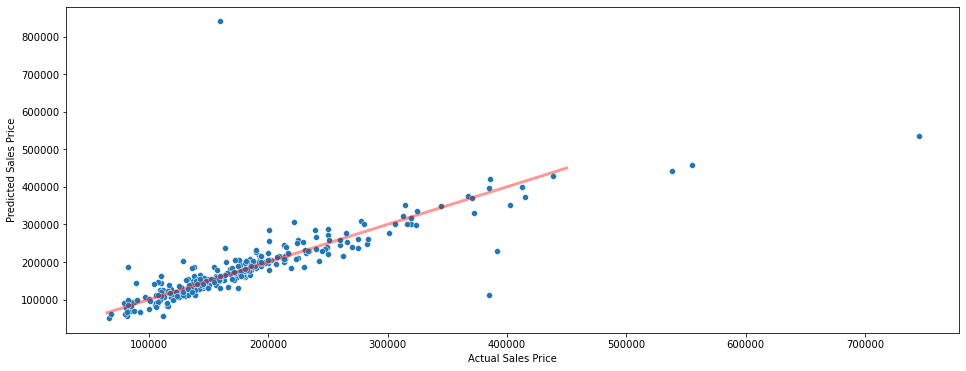

                    params  mean_test_neg_mean_squared_error  \
10  {'Ridge__alpha': 1000}                     -1.079767e+09   
9    {'Ridge__alpha': 550}                     -9.664786e+08   
8    {'Ridge__alpha': 500}                     -9.530582e+08   
0    {'Ridge__alpha': 0.1}                     -9.495428e+08   
7    {'Ridge__alpha': 450}                     -9.393476e+08   
6    {'Ridge__alpha': 350}                     -9.108262e+08   
5    {'Ridge__alpha': 300}                     -8.958725e+08   
4    {'Ridge__alpha': 250}                     -8.803391e+08   
1      {'Ridge__alpha': 1}                     -8.586175e+08   
3    {'Ridge__alpha': 100}                     -8.293585e+08   
2     {'Ridge__alpha': 10}                     -8.139960e+08   

    mean_test_neg_mean_absolute_error  mean_test_r2  
10                      -19748.164112      0.827599  
9                       -18685.136963      0.845642  
8                       -18548.165526      0.847772  
0              

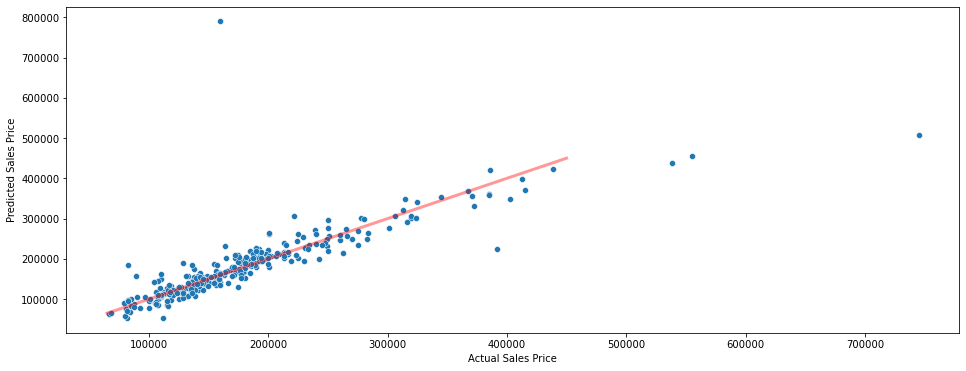

                          params  mean_test_neg_mean_squared_error  \
10  {'Elastic Net__alpha': 1000}                     -6.019006e+09   
9    {'Elastic Net__alpha': 550}                     -5.896862e+09   
8    {'Elastic Net__alpha': 500}                     -5.870360e+09   
7    {'Elastic Net__alpha': 450}                     -5.838279e+09   
6    {'Elastic Net__alpha': 350}                     -5.748451e+09   
5    {'Elastic Net__alpha': 300}                     -5.682815e+09   
4    {'Elastic Net__alpha': 250}                     -5.593331e+09   
3    {'Elastic Net__alpha': 100}                     -4.897527e+09   
2     {'Elastic Net__alpha': 10}                     -1.915356e+09   
1      {'Elastic Net__alpha': 1}                     -9.441569e+08   
0    {'Elastic Net__alpha': 0.1}                     -8.110154e+08   

    mean_test_neg_mean_absolute_error  mean_test_r2  
10                      -56762.302103      0.016437  
9                       -56108.331601      0.036624

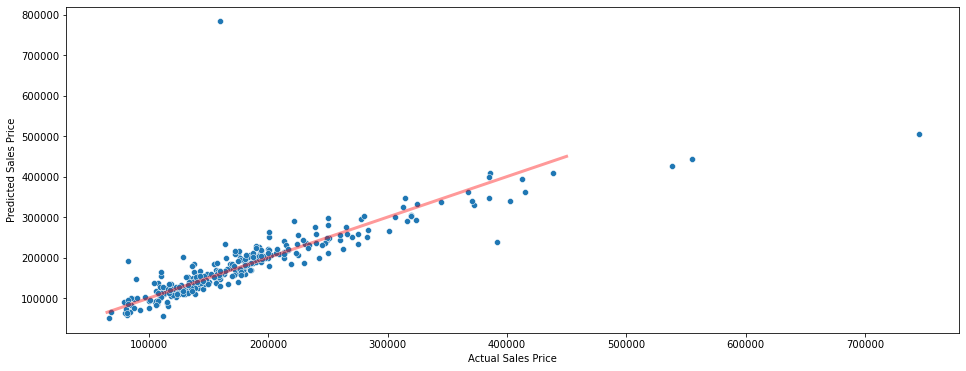

In [12]:
# Fit a regularized linear regression model
models = [('Lasso', linear_model.Lasso(max_iter=100000)),
           ('Ridge', linear_model.Ridge(max_iter=100000)),
           ('Elastic Net', linear_model.ElasticNet(max_iter=100000))]

for model_name, model in models:
    params = {model_name + '__alpha' : (0.1,1,10,100,250,300,350,450,500,550,1000)}
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('norm', ct),
        (model_name, model)
    ])
    gs = GridSearchCV(estimator=pipeline, 
                      param_grid=params, 
                      cv=5,
                      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                      refit='neg_mean_squared_error')
    gs.fit(x_train, y_train)
    # Output results
    results = pd.DataFrame(gs.cv_results_)
    results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
    print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']])
    # Output the alpha that gives the best fit for the model
    print("Best ", model_name, " model:")
    print(gs.best_params_)
    # Print coefficients
    coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_[model_name].coef_, (1,-1)), columns=x_train.columns, index=['coeff'] )
    print(coeffs.sort_values(by='coeff', axis=1))
    if model_name == 'Lasso':
        lasso_coeffs = coeffs
    # Predict housing values for the test set using the best model
    y_test_hat = gs.predict(x_test)
    # Compute model evaluation metrics for the best model
    metrics(y_test, y_test_hat)
    # Plot actual vs. predicted
    plt.figure(figsize=(16,5))
    plot = sns.scatterplot(x=y_test, y=y_test_hat)
    plot.set(xlabel='Actual Sales Price', ylabel='Predicted Sales Price')
    plot.set_title('Predicted Sale Price vs. Actual Sale Price')
    plt.plot(np.array([65000.,450000.]), np.array([65000.,450000.]), color='red', alpha=0.4, linewidth=3)
    plt.show()

In [25]:
# The next block fails if we keep all variables, so we instead drop variables based on the results of the models above.
# Above, the regularized linear models had lower mean squared error than the non-regularized linear model.
# The Elastic Net and Ridge models only dropped five variables, so we choose to
# drop the variables that have a coefficient of zero in the Lasso model.

#pd.set_option('mode.chained_assignment', None)

cols_to_drop = lasso_coeffs.columns[(lasso_coeffs==0).iloc[0]].to_list()

# Make sure we only drop an ordinal variable's dummy if we drop ALL of that variable's dummies
#ordinal_var_counts_total = {'GarageYrBlt' : 0, 'LandSlope' : 0, 'ExterQual' : 0, 'ExterCond' : 0,
#                            'BsmtQual' : 0, 'BsmtCond' : 0, 'BsmtExposure' : 0, 'BsmtFinType1' : 0,
#                            'BsmtFinType2' : 0, 'HeatingQC' : 0, 'KitchenQual' : 0, 'Functional' : 0,
#                            'FireplaceQu' : 0, 'GarageFinish' : 0, 'GarageQual' : 0, 'GarageCond' : 0,
#                            'PoolQC' : 0, 'Fence' : 0, 'MoSold' : 0, 'YrSold' : 0}
#ordinal_var_counts_drop = copy.deepcopy(ordinal_var_counts_total)

#for col in x_train.columns:
#    prefix = col.split('_')[0]
#    if prefix in ordinal_var_counts_total.keys():
#        ordinal_var_counts_total[prefix] += 1
#for col in cols_to_drop:
#    prefix = col.split('_')[0]
#    if prefix in ordinal_var_counts_drop.keys():
#        ordinal_var_counts_drop[prefix] += 1

x_train_trunc = x_train.copy(deep=True)
x_test_trunc = x_test.copy(deep=True)

x_train_trunc.drop(cols_to_drop, axis=1, inplace=True)
x_test_trunc.drop(cols_to_drop, axis=1, inplace=True)

cont_cols_trunc = []
for col in cont_cols:
    if col not in cols_to_drop:
        cont_cols_trunc.append(col)

#for col in cols_to_drop:
#    prefix = col.split('_')[0]
#    if prefix in ordinal_var_counts_total:
#        if ordinal_var_counts_total[prefix] == ordinal_var_counts_drop[prefix]:
#            x_train_trunc.drop([col], axis=1, inplace=True)
#            x_test_trunc.drop([col], axis=1, inplace=True)
#    else:
#        x_train_trunc.drop([col], axis=1, inplace=True)
#        x_test_trunc.drop([col], axis=1, inplace=True)

In [27]:
# Fit linear model with polynomial features
params = {'poly__degree' : (2,3)}
ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols_trunc)
    ], remainder='passthrough')
pipeline = Pipeline([
    ('norm', ct),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('regr', linear_model.LinearRegression()),
])
gs = GridSearchCV(estimator=pipeline, 
                  param_grid=params, 
                  cv=5,
                  scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                  refit='neg_mean_squared_error')
gs.fit(x_train_trunc, y_train)

# Output results
results = pd.DataFrame(gs.cv_results_)
results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']])

# Output the number of degrees that gives the best fit for the polynomial model
print('Best linear model with polynomial features:')
print(gs.best_params_)

# Print coefficients
coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_['regr'].coef_, (1,-1)),
                      columns=gs.best_estimator_['poly'].get_feature_names(x_train_trunc.columns), index=['coeff'] )
print(coeffs.sort_values(by='coeff', axis=1))

# Predict housing values for the test set using the best polynomial model
y_test_hat = gs.predict(x_test_trunc)

# Compute model evaluation metrics for the best polynomial model
metrics(y_test, y_test_hat)

# Plot actual vs. predicted
plt.figure(figsize=(16,5))
plot = sns.scatterplot(x=y_test, y=y_test_hat)
plot.set(xlabel='Actual Sales Price', ylabel='Predicted Sales Price')
plot.set_title('Predicted Sale Price vs. Actual Sale Price')
plt.plot(np.array([65000.,450000.]), np.array([65000.,450000.]), color='red', alpha=0.4, linewidth=3)
plt.ylim((-100000000000000,100000000000000))
plt.show()

KeyboardInterrupt: 

                                      params  \
0  {'Lasso__alpha': 1150, 'poly__degree': 2}   
1  {'Lasso__alpha': 1200, 'poly__degree': 2}   
3  {'Lasso__alpha': 1350, 'poly__degree': 2}   
2  {'Lasso__alpha': 1300, 'poly__degree': 2}   

   mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
0                     -7.694161e+08                      -14858.055310   
1                     -7.683122e+08                      -14855.215119   
3                     -7.677224e+08                      -14856.949225   
2                     -7.675634e+08                      -14852.848441   

   mean_test_r2  
0      0.876277  
1      0.876453  
3      0.876583  
2      0.876593  
Best  Lasso  model with polynomial features:
{'Lasso__alpha': 1300, 'poly__degree': 2}
       BsmtQual_Ex MoSold_2  MasVnrType_BrkFace GarageYrBlt_2009.0  \
coeff          -1719.501736                            -1631.43291   

       MSZoning_RM^2  Exterior1st_Wd Sdng^2  Condition1_PosA Functiona

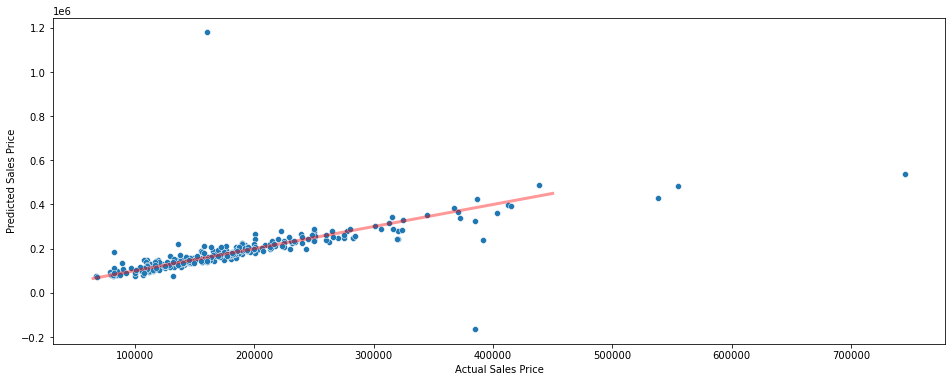

                                      params  \
3  {'Ridge__alpha': 1350, 'poly__degree': 2}   
2  {'Ridge__alpha': 1300, 'poly__degree': 2}   
0  {'Ridge__alpha': 1150, 'poly__degree': 2}   
1  {'Ridge__alpha': 1200, 'poly__degree': 2}   

   mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
3                     -1.412886e+09                      -23251.143185   
2                     -1.412693e+09                      -23224.355509   
0                     -1.412661e+09                      -23154.314446   
1                     -1.412572e+09                      -23175.259912   

   mean_test_r2  
3      0.773664  
2      0.773721  
0      0.773804  
1      0.773792  
Best  Ridge  model with polynomial features:
{'Ridge__alpha': 1200, 'poly__degree': 2}
       MSSubClass_30^2  MSZoning_RM^2  MedIncome UnempRate  \
coeff     -1135.840491    -1132.34018          -913.900447   

       UnempRate SchoolRating  Foundation_CBlock  SaleCondition_Abnorml^2  \
coeff    

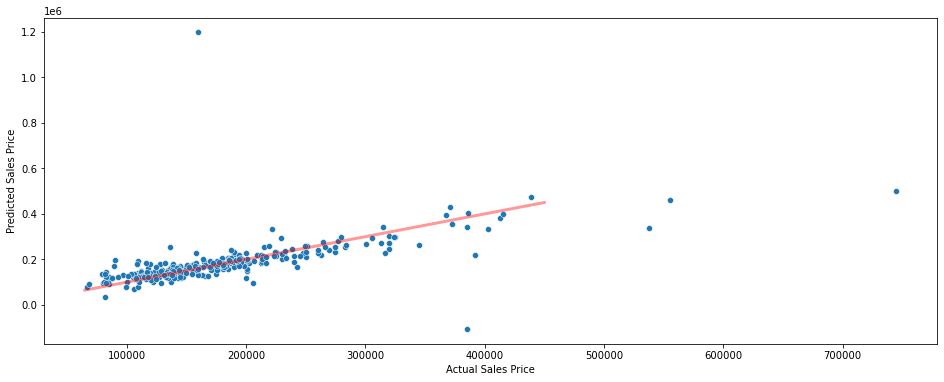

                                            params  \
3  {'Elastic Net__alpha': 1350, 'poly__degree': 2}   
2  {'Elastic Net__alpha': 1300, 'poly__degree': 2}   
1  {'Elastic Net__alpha': 1200, 'poly__degree': 2}   
0  {'Elastic Net__alpha': 1150, 'poly__degree': 2}   

   mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
3                     -4.752281e+09                      -51286.739786   
2                     -4.716206e+09                      -51106.089273   
1                     -4.638373e+09                      -50711.167843   
0                     -4.596302e+09                      -50494.885625   

   mean_test_r2  
3      0.221701  
2      0.227564  
1      0.240216  
0      0.247056  
Best  Elastic Net  model with polynomial features:
{'Elastic Net__alpha': 1150, 'poly__degree': 2}
       MSZoning_C (all)^2  MSSubClass_30^2  ExterQual_Fa^2  Foundation_Slab^2  \
coeff         -124.783166      -112.189227     -102.578389         -98.625239   

      

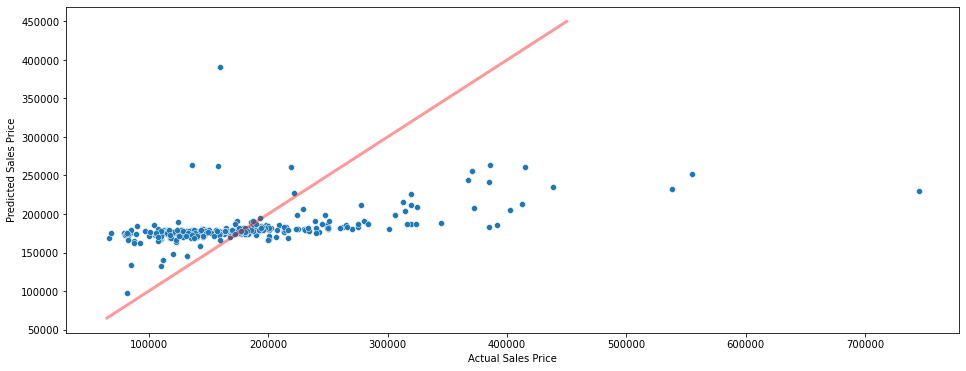

In [13]:
# The linear regression model with polynomial features of degree 2 performed best above, so we will regularize this model.
for model_name, model in models:
    params = {'poly__degree' : (2,),
              model_name + '__alpha' : (0.1,1,10,1150,1200,1250,1300,1350)}
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols_trunc)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('norm', ct),
        ('poly', PolynomialFeatures(include_bias=False)),
        (model_name, model)
    ])
    gs = GridSearchCV(estimator=pipeline, 
                      param_grid=params,
                      cv=5,
                      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                      refit='neg_mean_squared_error')
    gs.fit(x_train_trunc, y_train)
    # Output results
    results = pd.DataFrame(gs.cv_results_)
    results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
    print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']])
    # Output the alpha that gives the best fit for the model
    print("Best ", model_name, " model with polynomial features:")
    print(gs.best_params_)
    # Print coefficients
    coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_[model_name].coef_, (1,-1)),
                          columns=gs.best_estimator_['poly'].get_feature_names(x_train_trunc.columns), index=['coeff'] )
    print(coeffs.sort_values(by='coeff', axis=1))
    # Predict housing values for the test set using the best model
    y_test_hat = gs.predict(x_test_trunc)
    # Compute model evaluation metrics for the best model
    metrics(y_test, y_test_hat)
    # Plot actual vs. predicted
    plt.figure(figsize=(16,5))
    plot = sns.scatterplot(x=y_test, y=y_test_hat)
    plot.set(xlabel='Actual Sales Price', ylabel='Predicted Sales Price')
    plot.set_title('Predicted Sale Price vs. Actual Sale Price')
    plt.plot(np.array([65000.,450000.]), np.array([65000.,450000.]), color='red', alpha=0.4, linewidth=3)
    plt.show()